# Dimensionality Reduction with the Proper Orthogonal Decomposition (POD)
This notebook takes the Snapshots and compress the data using the POD

Let us create the mesh from the OpenFOAM nodes and cells

In [1]:
from pyforce.tools.write_read import ReadFromOF

path_snaps = '../../../Data/MSFR/'

of = ReadFromOF(path_snaps+'OVERSPEED/', mode='pyvista')
domain = of.create_mesh()

  warnings.warn('The mesh contains more than one cell type.')



Hexahedron cells selected


Let us import the snapshots, variable names and time

In [2]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load('Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load('Results/times.npz')['fom_times']

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, ("Lagrange", 1)),
    FunctionSpace(domain, VectorElement("Lagrange", domain.ufl_cell(), 1)),
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load('Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us split the snapshots into train and test and predict.

In [3]:
from sklearn.model_selection import train_test_split

Nt = len(fom_times)

_indices = np.arange(0, Nt)
train_indices, test_indices = train_test_split(_indices, test_size=0.2, random_state=42)

train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)

train_snaps = dict()

for field_i, field in enumerate(var_names):
    train_snaps[field] = FunctionsList(fun_spaces[field_i])
    for ii in train_indices:
        train_snaps[field].append(snaps[field](ii) / snaps[field](0).max())

## POD Training Phase
Let us compute the POD modes using the randomized SVD method.

In [4]:
from pyforce.offline.pod import DiscretePOD

pod_offline = {
    field: DiscretePOD(train_snap=train_snaps[field], name=field, Nmax=50, random=True)
    for field in var_names
}

Let us plot the singular values and the cumulative energy

Text(0, 0.5, 'Residual energy')

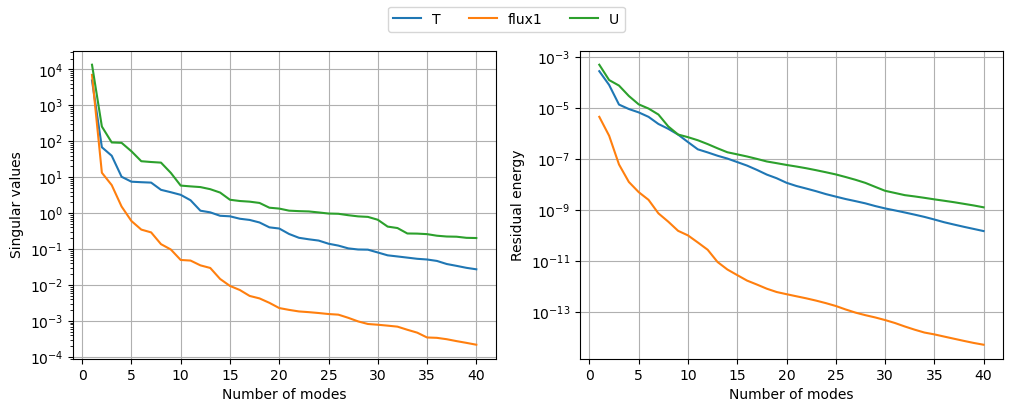

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(12, 4))

Nplot=np.arange(1, 41)
for field in var_names:
    axs[0].semilogy(Nplot, pod_offline[field].sing_vals[:max(Nplot)], label=field)
    axs[1].semilogy(Nplot, 1 - np.cumsum(pod_offline[field].sing_vals**2)[:max(Nplot)]/np.sum(pod_offline[field].sing_vals**2), label=field)

Lines, Labels = axs[0].get_legend_handles_labels()
fig.legend(Lines, Labels, loc='upper center', ncols=4)

for ax in axs:
    ax.set_xlabel('Number of modes')
    ax.grid()
axs[0].set_ylabel('Singular values')
axs[1].set_ylabel('Residual energy')

Let us project the snapshots onto the POD modes to obtain the coefficients.

In [13]:
max_rank = 15

Vh_train = dict()
for field in var_names:
    Vh_train[field] = pod_offline[field].modes.return_matrix().T[:max_rank] @ train_snaps[field].return_matrix()

Let us generate and store the POD modes

In [14]:

import os

path_offline = 'Results/POD_offline/'
os.makedirs(path_offline, exist_ok=True)

for field in var_names:
    np.savez_compressed(path_offline+f'POD_{field}_modes.npz',
                        modes = pod_offline[field].modes.return_matrix()[:, :max_rank])
    np.savez_compressed(path_offline+f'POD_{field}_sing_vals.npz',
                        sing_vals = pod_offline[field].sing_vals[:max_rank])
    np.savez_compressed(path_offline+f'POD_{field}_Vh_train.npz',
                        Vh_train = Vh_train[field])


Let us plot the POD modes

[Text(0.5, 1.0, 'T'), Text(0.5, 1.0, 'flux1'), Text(0.5, 1.0, 'U')]

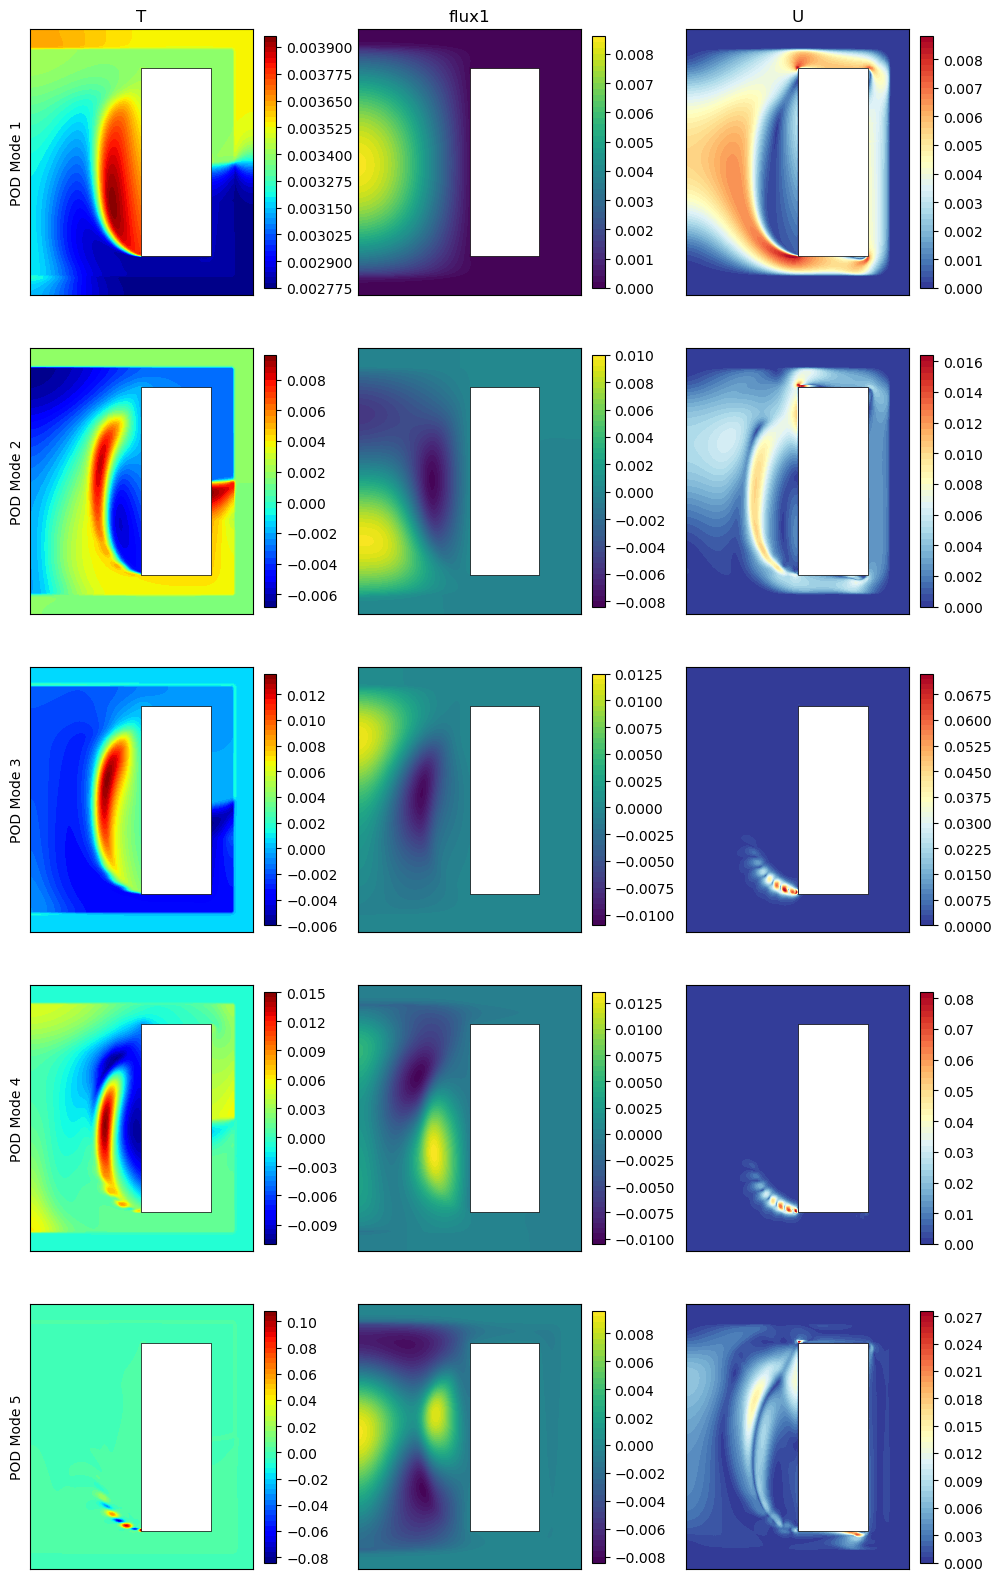

In [20]:
from utils import plot_contour
from matplotlib import cm

mode_to_plot = np.arange(0, 5, 1)

mesh_to_plot = np.stack([domain.geometry.x[:, 0], domain.geometry.x[:, 2]], axis=1)

nrows = len(mode_to_plot)
ncols = len(var_names)

cmaps = [cm.jet, cm.viridis, cm.RdYlBu_r]

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

for row in range(nrows):
    for col, field in enumerate(var_names):
        mode = pod_offline[field].modes(mode_to_plot[row])
        vec_mode_to_plot = True if is_vector[col] else None
        cont = plot_contour(axs[row, col], mesh_to_plot, mode, levels=50, vec_mode_to_plot=vec_mode_to_plot, cmap=cmaps[col])
        cbar = fig.colorbar(cont, ax=axs[row, col], fraction=0.046, pad=0.04)
    axs[row, 0].set_ylabel(f'POD Mode {mode_to_plot[row]+1}')

[axs[0, col].set_title(var_names[col]) for col in range(ncols)]